# Honey, I Shrunk the Data

Anthony Finch

--------------------

In *Is Bigger Really Better?*, we asked how we might go about commanding a squad of robots to find a needle in a warehouse full of hay if we couldn't actually tell the robots what to look for.  We considered three potentially helpful steps in this process, although none of these steps would completely solve our problem.

In this post, we'll explore the first helpful step that we could ask the robots to take: mapping out the warehouse to help us in our future search efforts.



# A Map that Leads to Needles

Let's consider a large, multi-dimensional dataset.  For now, this dataset is going to represent our hay.

To build this dataset, we're going to use some random number generators from `numpy`.  In fact, we're going to create three different sets of data.  The difference between these data sets is in how they're related to one another.  The features aren't all going to be independent.  In other words, the value for one feature is going to inform the value of another feature.  This is often true in real data.  It will also become very important later on.

For our analysis, we're going to make three sets of data, each of which is going to be split into a *training* set and a *validation* set.  We're going to use the training set to build our compression algorithms, and we're going to use the validation set to see how good those algorithms are.

### Mapmakers, Mapmakers, Make Me Some Maps

Right now, we're looking for some algorithms which will help us to take these 4-dimensional datasets and crush them down into something smaller and more manageable.  For now, let's say that we want to get down to just 2 dimensions.  Fittingly, this operation is called *dimensionality reduction* or *compression*.  This is considered to be an *Unsupervised Learning* task because we don't have an external target that we're using to evaluate our algorithm.  It's important to understand that this **does not** mean that our algorithms are necessarily undirected.  We still have a clear goal in mind, it's just that our goal is defined within the dataset instead of requiring information about some external process or value.

There are many ways to achieve this, but let's remind ourselves of our requirements:

1. The data is an input - we put in all of the features.
2. The output is smaller (say, two dimensions).
3. We need a way to reconstruct our original features from the data.

Our first two inputs are going to help us to set up our problem, and the last is going to be our evaluation or optimization metric.  In short, we're going to try to create a set of rules which transforms our dataset into a smaller, but still useful, version of itself.  

In this post, we'll explore two methods for solving this problem.  In the first version of this solution, we'll limit ourselves to using only linear transformations to make this compression.  Linear algorithms are nice to work with because they're computationally cheap and conceptually simple; however, they do leave a lot to be desired.  In our second algorithm, we will introduce nonlinear transformations that will make our algorithm significantly better at compressing the data, but which will also be significantly more complex.




### Table of Contents

* <a href=#build>Building Testing Data</a>
* <a href=#pca>The Mathematics of Principal Components</a>
* <a href=#pca_net>PCA with Neural Networks</a>
* <a href=#autoenc>Autoencoders</a>
* <a href=#review>Review</a>

# Building A Dataset <a name='build' />

In [2]:
import numpy as np
import pandas as pd

In [149]:
#Hot Tip: Don't know how to use the np.random package?
#Try using the command help(np.random) to see which distributions
#are available and use help(np.random.normal) to see what the API
#looks like!

#Set your desired number of data points.
N_train = 100000
N_test = 10000

#Dataset 1 - these features are completely independent
f1_1 = np.random.normal(0, 1, N_train)
f1_2 = np.random.uniform(0, 1, N_train)
f1_3 = np.random.exponential(1, N_train)
f1_4 = np.random.chisquare(1, N_train)

df_1 = pd.DataFrame({
    'f1' : f1_1,
    'f2' : f1_2,
    'f3' : f1_3,
    'f4' : f1_4
})

f1_1 = np.random.normal(0, 1, N_test)
f1_2 = np.random.uniform(0, 1, N_test)
f1_3 = np.random.exponential(1, N_test)
f1_4 = np.random.chisquare(1, N_test)

df_1_test = pd.DataFrame({
    'f1' : f1_1,
    'f2' : f1_2,
    'f3' : f1_3,
    'f4' : f1_4
})


#Dataset 2 - these features are linearly correlated
hidden_feature_1 = np.random.normal(0,1,N_train)
hidden_feature_2 = np.random.normal(0,1,N_train)

f2_1 = np.random.normal(0,1,N_train) + hidden_feature_1 - hidden_feature_2
f2_2 = np.random.normal(0,1,N_train) - hidden_feature_1 + hidden_feature_2
f2_3 = np.random.normal(0,1,N_train) + hidden_feature_1 + hidden_feature_2 - 1
f2_4 = np.random.normal(0,1,N_train) - hidden_feature_1 - hidden_feature_2 + 1

df_2 = pd.DataFrame({
    'f1' : f2_1,
    'f2' : f2_2,
    'f3' : f2_3,
    'f4' : f2_4
})

hidden_feature_1 = np.random.normal(0,1,N_test)
hidden_feature_2 = np.random.normal(0,1,N_test)

f2_1 = np.random.normal(0,1,N_test) + hidden_feature_1 - hidden_feature_2
f2_2 = np.random.normal(0,1,N_test) - hidden_feature_1 + hidden_feature_2
f2_3 = np.random.normal(0,1,N_test) + hidden_feature_1 + hidden_feature_2 - 1
f2_4 = np.random.normal(0,1,N_test) - hidden_feature_1 - hidden_feature_2 + 1

df_2_test = pd.DataFrame({
    'f1' : f2_1,
    'f2' : f2_2,
    'f3' : f2_3,
    'f4' : f2_4
})


#Dataset_3 - these features have complex nonlinear relationships
f3_1 = np.random.normal(0,1,N_train)
f3_2 = np.abs(f3_1) - np.random.exponential(1,N_train)
f3_3 = f3_1*np.random.chisquare(1,N_train)
f3_4 = f3_3/(1+np.abs(f3_2))

df_3 = pd.DataFrame({
    'f1' : f3_1,
    'f2' : f3_2,
    'f3' : f3_3,
    'f4' : f3_4
})

f3_1 = np.random.normal(0,1,N_test)
f3_2 = np.abs(f3_1) - np.random.exponential(1,N_test)
f3_3 = f3_1*np.random.chisquare(1,N_test)
f3_4 = f3_3/(1+np.abs(f3_2))

df_3_test = pd.DataFrame({
    'f1' : f3_1,
    'f2' : f3_2,
    'f3' : f3_3,
    'f4' : f3_4
})

### Examining Our Handiwork

Now, let's take a quick look at what these distributions look like using Seaborn's `pairplot`s.

In [107]:
import seaborn as sns

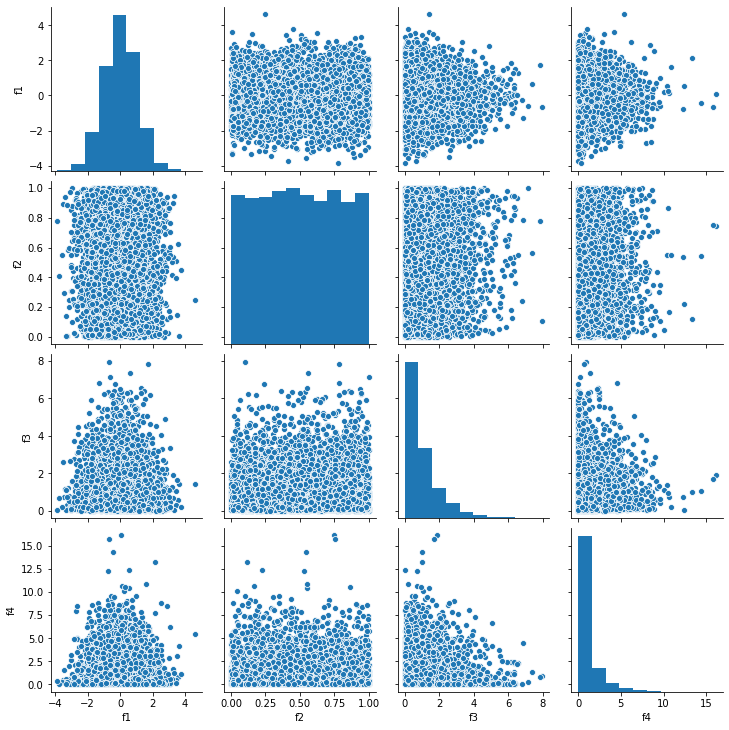

In [150]:
sns.pairplot(df_1_test)

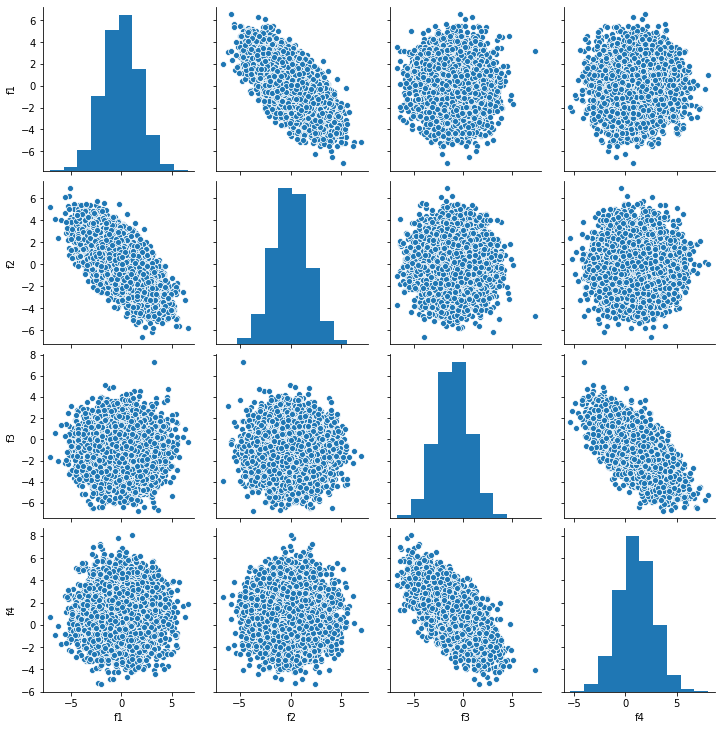

In [151]:
sns.pairplot(df_2_test)

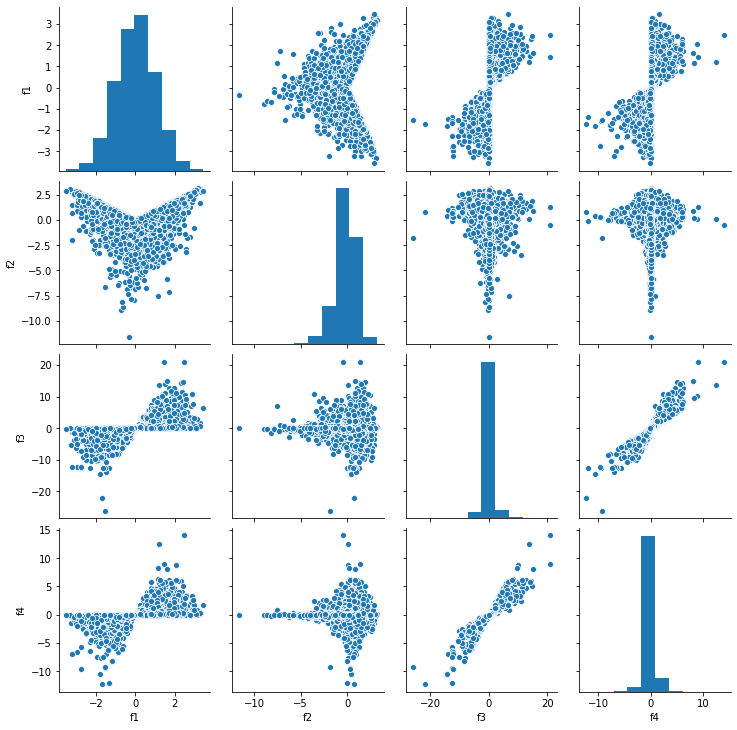

In [152]:
sns.pairplot(df_3_test)

# Linear Dimensionality-Reduction: The Mathematics of PCA <a name='pca' />

Let's harken back to our introductory Linear Algebra classes for a few moments.  If you didn't take Linear Algebra, that's okay, too!  This is pretty simple.

We can express our data as an $M$-dimensional dataset with $N$ points.  In our case, we have $N = 10000$ (our number of data points) and $M = 4$ (our number of features).  Fortunately for us, numpy can do this for us pretty easily.

We'll express this matrix as an $N x M$ matrix ($N$ rows, $M$ columns).

In [112]:
np.matrix(df_1).shape

(10000, 4)

If you did take linear algebra, you'll probably remember doing a lot of matrix multiplication.  Remember that, when we multiply matrices, we multiply the **rows** of the first matrix by the **columns** of the second matrix.

For example, let's say that we have the matrix $A$ and another matrix $B$.

In [113]:
A = np.matrix([[1,2], [3,4]])
A

matrix([[1, 2],
        [3, 4]])

In [114]:
B = np.matrix([[5,6],[7,8]])
B

matrix([[5, 6],
        [7, 8]])

If we want to multiply $A$ by $B$ (this is denoted $AB$), then we would multiply the first row of $A$ by the first column of $B$ to get the top-left value.  Then we'd multiply the first row of $A$ by the second column of $B$ to get the top right value, and so on.  It would look like this:

$$AB = \left[\begin{array}[cc]] 1*5 + 2*7 & 1*6 + 2*8 \\ 3*5 + 4*7 & 3*6 + 4*8\end{array}\right]$$

In [115]:
#WARNING: using the numpy.multiply() command gives the element-wise product, which isn't what we want!
np.matmul(A,B)

matrix([[19, 22],
        [43, 50]])

The interesting thing about matrix multiplication is that it doesn't require matrices of the same size.  Instead, the number of rows in the first matrix has to match the number of columns in the second matrix, and the number of rows in the second matrix has to match the number of columns in the first.  In other words, it's completely fine if we create a new matrix $C$ like the following.

In [116]:
C = np.matrix([[9],[10]])
C

matrix([[ 9],
        [10]])

In [117]:
np.matmul(A,C)

matrix([[29],
        [67]])

Wait - we just *reduced the dimensionality* of $A$!

Huzzah!  Let's go eat lunch.


# Optimizing the Dimensionality-Reduction

Let's summarize our observation - we can create a smaller dimensionality by building a matrix that has fewer columns than our current matrix.  That's it.  By the way, that's the same thing as saying that we can write an equation like this:

$$ \alpha_1*x_1 + \alpha_2*x_2 = \text{Something valuable}$$

That is, assuming we're trying to reduce to just a single dimension from two starting dimensions.

The point is, we can find coefficients (in this case, $\alpha_1$ and $\alpha_2$) which will give us fewer dimensions.  This satisfies two of our conditions:

1. The method takes our data as an input.
2. It produces a smaller matrix than we started out with.

Unfortunately, we still have one requirement left:

3. We need to be able to get back to our original matrix (or close to it)!

This last requirement is, in fact, an optimization task.  For the sake of brevity, I'm going to use the classic mathematics technique: ICBST (It Can Be Shown That) this is equal to the eigenvector decomposition of the centered, normalized sample covariance matrix.

If that seems kind of confusing, don't worry - there are conceptually simpler ways to get arrive at this solution.

The resulting vectors are known as the *Principal Components.*  Typically, this process is called PCA or Principal Components Analysis.  These are linearly independent (covariance = 0) vectors.  If we have a full set (number of PCs = rank of the matrix) of principal components, we can always recreate our original data.

The following code is going to Center (adjust so the mean is 0) and Normalize (adjust so variance is 1) our data.  This prevents the algorithm from prioritizing big features over smaller ones.  Then, we obtain a set of all four Principal Components and recover our original data and verify that it looks right.

In [118]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [119]:
pca = PCA()
norm = StandardScaler()

comp = pca.fit_transform(norm.fit_transform(df_1))

In [120]:
pca.components_

array([[-0.70559913, -0.14929965,  0.11252344,  0.68350418],
       [-0.19137352,  0.5268955 ,  0.79993313, -0.21415949],
       [ 0.03036212, -0.83615353,  0.49566442, -0.23289954],
       [ 0.68160413,  0.03062707,  0.31900195,  0.65781119]])

In [121]:
norm.inverse_transform(pca.inverse_transform(comp))

array([[-1.39273625,  0.80542328,  0.35653182,  0.15705697],
       [-0.162298  ,  0.66405103,  0.09555683,  1.92251822],
       [-0.21346884,  0.6682919 ,  0.34766301,  8.04379508],
       ...,
       [ 0.84439156,  0.30887737,  1.67186785,  0.47812372],
       [-0.84802586,  0.20799498,  0.98079344,  3.67834324],
       [-0.16964321,  0.09379268,  0.40473147,  0.24865342]])

In [122]:
df_1.values

array([[-1.39273625,  0.80542328,  0.35653182,  0.15705697],
       [-0.162298  ,  0.66405103,  0.09555683,  1.92251822],
       [-0.21346884,  0.6682919 ,  0.34766301,  8.04379508],
       ...,
       [ 0.84439156,  0.30887737,  1.67186785,  0.47812372],
       [-0.84802586,  0.20799498,  0.98079344,  3.67834324],
       [-0.16964321,  0.09379268,  0.40473147,  0.24865342]])

### How Good is PCA?

Now that we've seen how to use PCA, let's see how effective it is when we only use two features instead of four.  After all, our motivation for this experiment was to compress data!

For this experiment, I'm going to use an SKLearn `pipeline`.  This is just going to wrap up the two operations we used before and make it slightly easier to call on them together.

In [135]:
# We're going to use this function to plot our results and see how good they are

import matplotlib.pyplot as plt

def plot_pairs(data_orig, data_new):
    N = data_orig.shape[1]
    fig, axes = plt.subplots(nrows=N, ncols=1, figsize=(15,15))
    
    for n in range(N):
        axes[n].scatter(data_orig[:,n], data_new[:,n], alpha = 0.05)
        axes[n].plot([min(data_orig[:,n]), max(data_orig[:,n])], [min(data_orig[:,n]), max(data_orig[:,n])], color = 'orange')
    
    fig.suptitle('Reconstructed Data From Dataset 1')
    
    return fig

In [123]:
from sklearn import pipeline

In [153]:
pipe_1 = pipeline.Pipeline(
    [('norm', StandardScaler()),
    ('pca', PCA(n_components = 2))]
)

pipe_1.fit(df_1)

comp_1 = pipe_1.transform(df_1_test)

recon_1 = pipe_1.inverse_transform(comp_1)

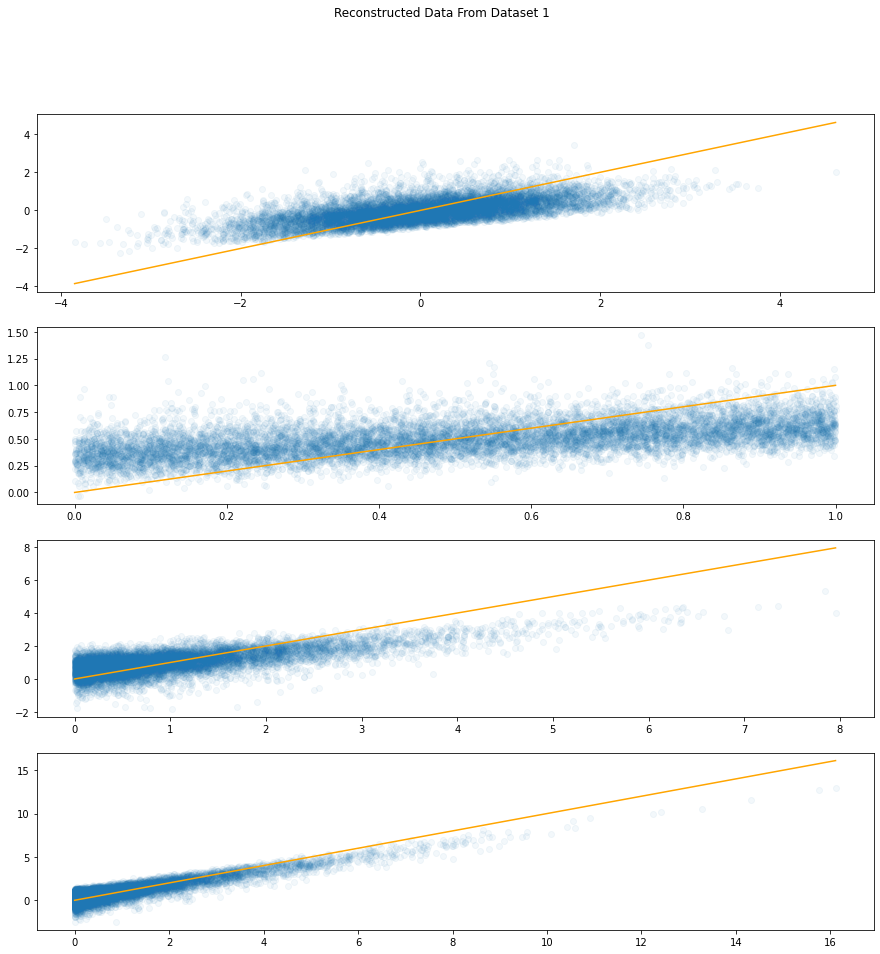

In [154]:
fig = plot_pairs(df_1_test.values, recon_1)
fig.show()

Based on these graphs, we can conclude that PCA is able to capture some of the variability in the data, but it's far from flawless.  We can also use the mean squared error (MSE) as a numerical measure of how good our reconstruction is.  Note that 0 is perfect and the size of the error is based on the variance is the data, which is why we've normalized our data before computing the MSE.

In [155]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import Normalizer

In [156]:
tmp_n = Normalizer()
mean_squared_error(tmp_n.fit_transform(df_1_test.values), tmp_n.transform(recon_1))

0.0891492374449166

In [157]:
pipe_2 = pipeline.Pipeline(
    [('norm', StandardScaler()),
    ('pca', PCA(n_components = 2))]
)

pipe_2.fit_transform(df_2)

comp_2 = pipe_2.fit_transform(df_2_test)

recon_2 = pipe_2.inverse_transform(comp_2)

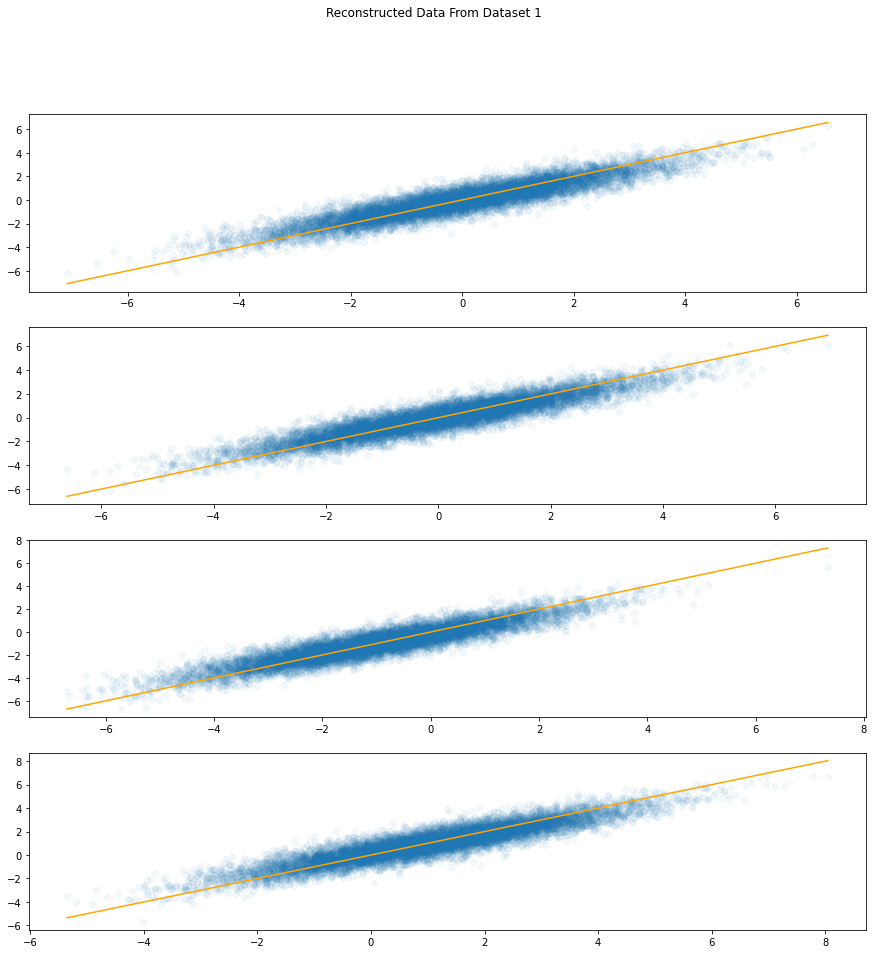

In [159]:
fig = plot_pairs(df_2_test.values, recon_2)
fig.show()

PCA did *much* better with our second dataset!

This is because that dataset was known to have linearly-related features, so PCA is well-suited to the task.  Once again, we can compute the MSE; however, we really can't compare the MSE result from this dataset to the previous one because they're different datasets.  In the future, we'll compare these MSE measures to the numbers we get from alternative algorithms.

In [161]:
tmp_n = Normalizer()
mean_squared_error(tmp_n.fit_transform(df_2_test.values), tmp_n.transform(recon_2))

0.06913765452419332

In [162]:
pipe_3 = pipeline.Pipeline(
    [('norm', StandardScaler()),
    ('pca', PCA(n_components = 2))]
)

pipe_3.fit_transform(df_3)

comp_3 = pipe_3.fit_transform(df_3_test)

recon_3 = pipe_3.inverse_transform(comp_3)

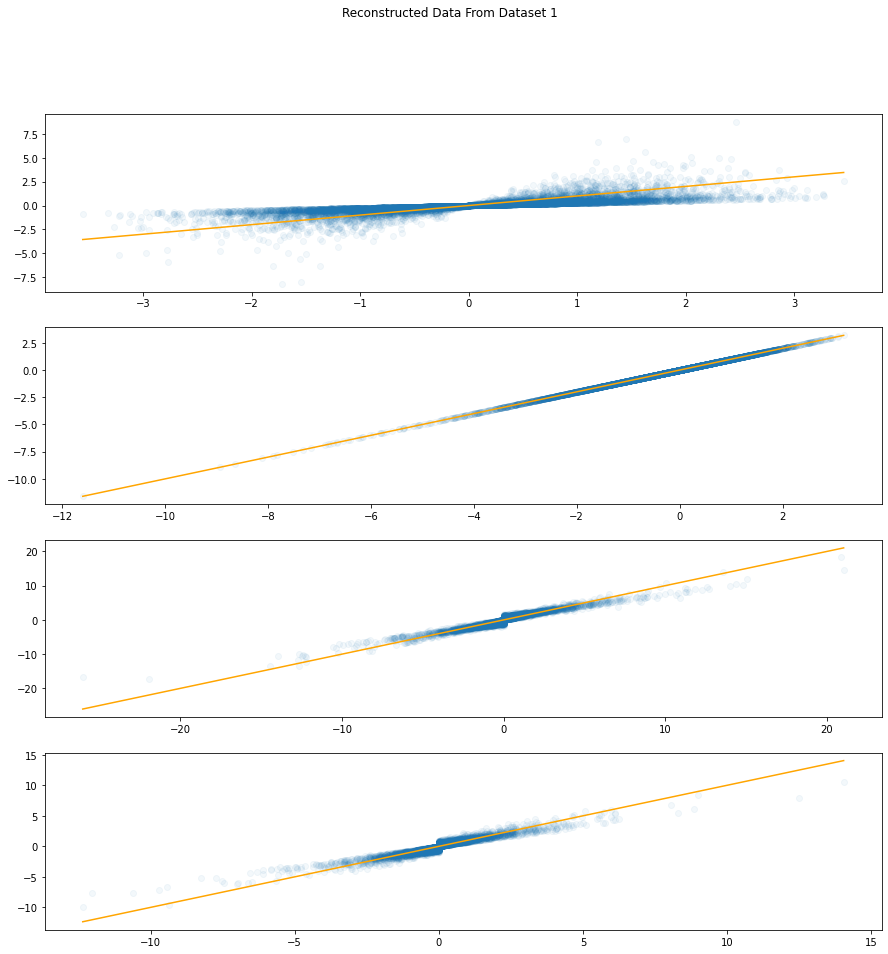

In [163]:
fig = plot_pairs(df_3_test.values, recon_3)
fig.show()

In [164]:
tmp_n = Normalizer()
mean_squared_error(tmp_n.fit_transform(df_3_test.values), tmp_n.transform(recon_3))

0.07180342373762666

# PCA Without the Tricks <a name='pca_net' />

When we first introduced PCA, I waved my hands around and said 'MATH'.  That wasn't a very satisfying way to learn about the technique, but deriving PCA from scratch would require me to cover lots of linear algebra topics (eigenvectors/values, covariance matrices, Lagrange multipliers).  Instead, we'll focus on a more intuitive way to understand PCA - using neural networks!


# Neural Networks - A Primer

Eventually, I'll get around to making an introduction to neural networks as its own dedicated entry in this blog.  For now, though, let's cover just the very basics of neural networks.

A 'neural network' involves lots of matrix multiplication.  We construct a set of 'layers', each consisting of a collection of weights (a vector) which we multiply by the outputs of the previous layer.  Let's look at an example.

![A Simple Autoencoder](./img/autoenc_diagram.jpg)


This transformation is *exactly the same* as our PCA transformation!  It has the same number of variables and parameters, and the outputs in the middle (the 'PCA' transformation) should look very similar to our regular PCA transformation.

Now, we can use standard neural network fitting mechanisms (adam, SGD, etc.) to get our answer.

In [215]:
from sklearn.base import TransformerMixin
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense

class fake_PCA(TransformerMixin):
    
    def __init__(self, n_components = 2):
        self.n_components = n_components
        self.pca_mod = None
        self.inv_mod = None
        
    def _build_model(self, n_feats):
        
        inputs = Input(shape = (n_feats,))
        pca_feats = Dense(self.n_components, activation = 'linear')(inputs)
        recon_func = Dense(n_feats, activation = 'linear')
        
        recon_feats = recon_func(pca_feats)
        
        pca_inputs = Input(shape = (self.n_components,))
        recon_feats_partial = recon_func(pca_inputs)
        
        self.pca_mod = Model(inputs = inputs, outputs = pca_feats)
        self.full_inv_mod = Model(inputs = inputs, outputs = recon_feats)
        self.inv_mod = Model(inputs = pca_inputs, outputs = recon_feats_partial)
        
        self.full_inv_mod.compile(optimizer = 'adam', loss = 'mean_squared_error')

    #SKLearn transformers should take y as an optional argument, even when it isn't necessary, to make sure that they can work with pipelines
    def fit(self, data, y = None, n_epochs = 10, batch_size = 100): 
        self._build_model(data.shape[1])
        
        self.full_inv_mod.fit(
            np.array(data),
            np.array(data),
            epochs = n_epochs,
            batch_size = batch_size
        )
        
        return self
    
    def transform(self, data):
        return self.pca_mod.predict(data)
    
    def inverse_transform(self, data):
        return self.inv_mod.predict(data)

In [216]:
f_pipe_1 = pipeline.Pipeline(
    [('norm', StandardScaler()),
    ('pca', fake_PCA(n_components = 2))]
)

f_pipe_1.fit(df_1, pca__n_epochs = 15)

f_comp_1 = f_pipe_1.transform(df_1_test)

f_recon_1 = f_pipe_1.inverse_transform(f_comp_1)

Epoch 1/15
1000/1000 [==============================] - 1s 892us/step - loss: 0.6998
Epoch 2/15
1000/1000 [==============================] - 1s 845us/step - loss: 0.5036
Epoch 3/15
1000/1000 [==============================] - 1s 842us/step - loss: 0.5032
Epoch 4/15
1000/1000 [==============================] - 1s 835us/step - loss: 0.5032
Epoch 5/15
1000/1000 [==============================] - 1s 841us/step - loss: 0.5031
Epoch 6/15
1000/1000 [==============================] - 1s 850us/step - loss: 0.5031
Epoch 7/15
1000/1000 [==============================] - 1s 847us/step - loss: 0.5030
Epoch 8/15
1000/1000 [==============================] - 1s 841us/step - loss: 0.5029
Epoch 9/15
1000/1000 [==============================] - 1s 840us/step - loss: 0.5028
Epoch 10/15
1000/1000 [==============================] - 1s 848us/step - loss: 0.5026
Epoch 11/15
1000/1000 [==============================] - 1s 841us/step - loss: 0.5025
Epoch 12/15
1000/1000 [==============================] - 1s 841

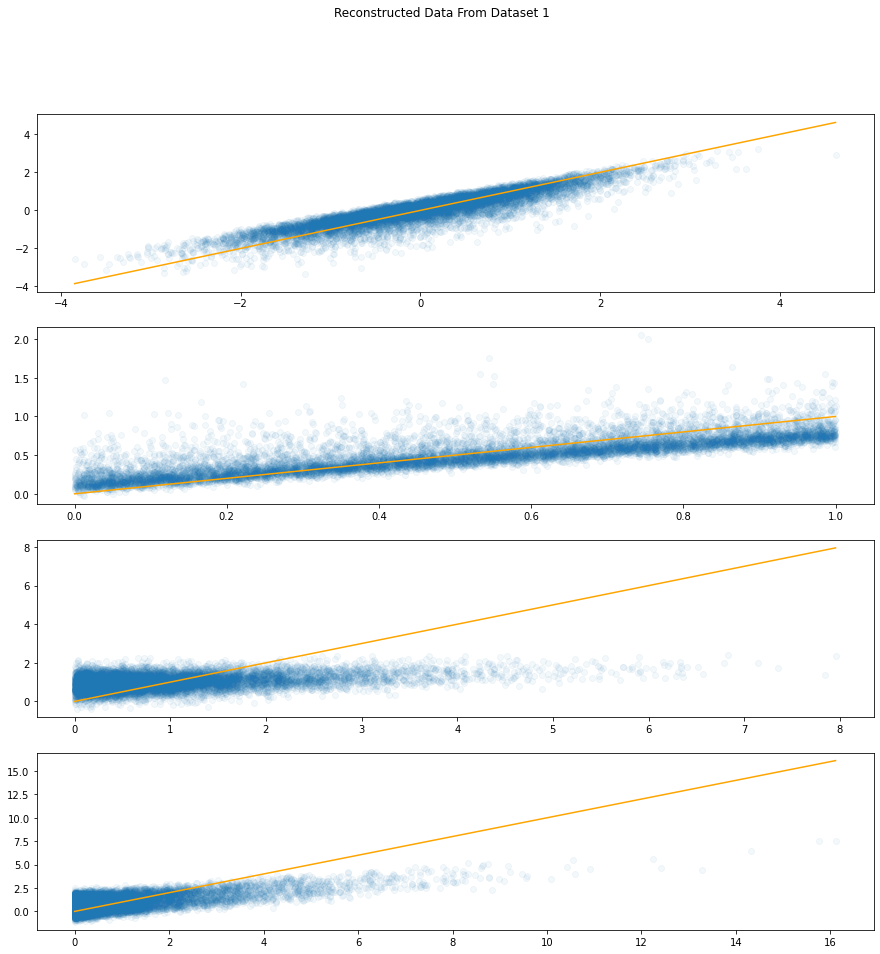

In [217]:
fig = plot_pairs(df_1_test.values, f_recon_1)
fig.show()

In [218]:
tmp_n = Normalizer()
mean_squared_error(tmp_n.fit_transform(df_1_test.values), tmp_n.transform(f_recon_1))

0.08987328587964259

While our error rate isn't *exactly* the same as the error we saw using PCA above, it's very close.  Any differences are coming from the fact that the neural network is a random process.  With an infinite number of epochs and guaranteed optimization, the neural network would approach the exact same solution as PCA, since they're optimizing the exact same function.

### Intuition

This may help you gain some intuition into how PCA is working.  While the proof is complex, PCA is just an analytical solution to a simple optimization problem.  We're trying to find the optimal linear transformation that allows us to compress our dataset to a smaller number of features and then reconstruct the original data.

# Autoencoders <a name='autoenc' />

**I'll admit it - I've tricked you.**

While I presented our previous example as an easy way to understand PCA (and it is!), my primary motivation was to talk about neural networks.  See, one of the chief problems with PCA is that it assumes linear relationships between features.  The world is much more complex than that.

One way to solve for this problem is to use an extension to PCA called *Kernel PCA*.  This technique takes a non-linear transformation to the data and projects it into an inner product space (translation: it makes the data really big using some mathematical chicanery) and then performs PCA in that new space.  There are a few problems with this technique.  First of all, it's incredibly resource intensive - you have to construct a matrix of size $N x N$.  For reference, when I tried to do this for demonstration purposes on my machine, I got an error indicating that a 100k x 100k matrix would require more than 70 GB of space.  That just isn't practical for most problems.  The second problem (for us) is that KPCA isn't really invertible.  *In theory* you can train sometimes train an inverter to recover the original data, but in practice this isn't always the case.  

A much easier way to do this is to use a neural network, as we did above.  The example above is an extraordinarily simple example of an *autoencoder*, which is any neural network that learns to compess a dataset and then recover it again.  This can be incredibly useful, since it lets our network learn complex, nonlinear relationships in the data.  Of course, it can only do this if we use nonlinear transformation layers.

Let's take a look at what happens when we construct a slightly more complicated network.  While it may look a little scary, all you need to really know is that we use a nonlinear transformation to mess with the data a little bit between each of the layers.

![A more complex and general autoencoder](./img/complex_autoenc_diagram.png)

In [288]:
from sklearn.base import TransformerMixin
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout

class autoencoder(TransformerMixin):
    
    def __init__(self, n_components = 2):
        self.n_components = n_components
        self.pca_mod = None
        self.inv_mod = None
        
    def _build_model(self, n_feats):
        
        inputs = Input(shape = (n_feats,))
        dense_0 = Dense(n_feats*2, activation = 'tanh')(inputs)
        dense_1 = Dense(n_feats*4, activation = 'relu')(dense_0)
        drop_0 = Dropout(0.1)(dense_1)
        dense_2 = Dense(n_feats, activation = 'tanh')(drop_0)
        pca_feats = Dense(self.n_components, activation = 'linear')(dense_1)
        
        pca_inputs = Input(shape = (self.n_components,))
        
        dense01 = Dense(n_feats, activation = 'linear')(pca_inputs)
        dense11 = Dense(n_feats*2, activation = 'tanh')(dense01)
        dense21 = Dense(n_feats*4, activation = 'relu')(dense11)
        drop_1 = Dropout(0.1)(dense21)
        dense31 = Dense(n_feats, activation = 'tanh')(drop_1)
        recon_feats = Dense(n_feats, activation = 'linear')(dense31)
        
        
        self.pca_mod = Model(inputs = inputs, outputs = pca_feats)
        self.inv_mod = Model(inputs = pca_inputs, outputs = recon_feats)
        
        final_out = self.inv_mod(self.pca_mod(inputs))
        
        self.full_inv_mod = Model(inputs = inputs, outputs = final_out)
        
        
        self.full_inv_mod.compile(optimizer = 'adam', loss = 'mean_squared_error')

    #SKLearn transformers should take y as an optional argument, even when it isn't necessary, to make sure that they can work with pipelines
    def fit(self, data, y = None, n_epochs = 10, batch_size = 100, verbose = False): 
        self._build_model(data.shape[1])
        
        self.full_inv_mod.fit(
            np.array(data),
            np.array(data),
            epochs = n_epochs,
            batch_size = batch_size,
            verbose = verbose
        )
        
        return self
    
    def transform(self, data):
        return self.pca_mod.predict(data)
    
    def inverse_transform(self, data):
        return self.inv_mod.predict(data)

In [289]:
a_pipe_1 = pipeline.Pipeline(
    [('norm', StandardScaler()),
    ('auto', autoencoder(n_components = 2))]
)

a_pipe_1.fit(df_1, auto__n_epochs = 20)

a_comp_1 = a_pipe_1.transform(df_1_test)

a_recon_1 = a_pipe_1.inverse_transform(a_comp_1)

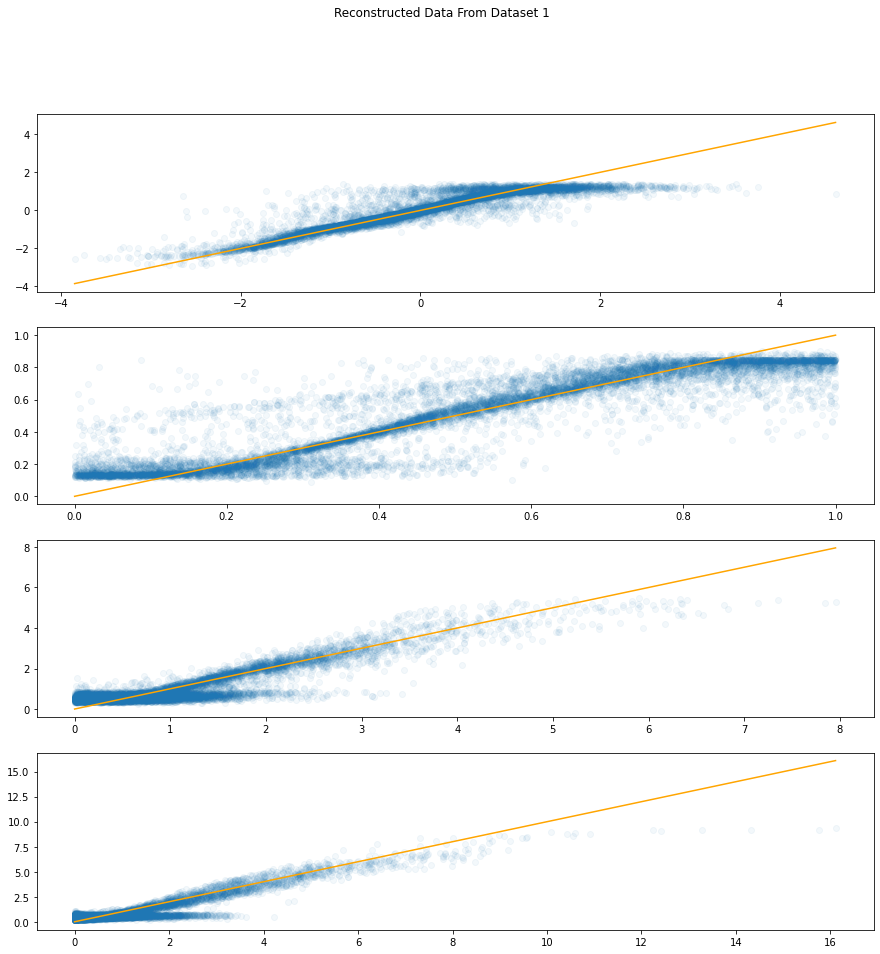

In [290]:
fig = plot_pairs(df_1_test.values, a_recon_1)
fig.show()

In [291]:
tmp_n = Normalizer()
mean_squared_error(tmp_n.fit_transform(df_1_test.values), tmp_n.transform(a_recon_1))

0.03446808565196767

In [295]:
a_pipe_2 = pipeline.Pipeline(
    [('norm', StandardScaler()),
    ('auto', autoencoder(n_components = 2))]
)

a_pipe_2.fit(df_2, auto__n_epochs = 50, auto__batch_size = 10)

a_comp_2 = a_pipe_2.transform(df_2_test)

a_recon_2 = a_pipe_2.inverse_transform(a_comp_2)

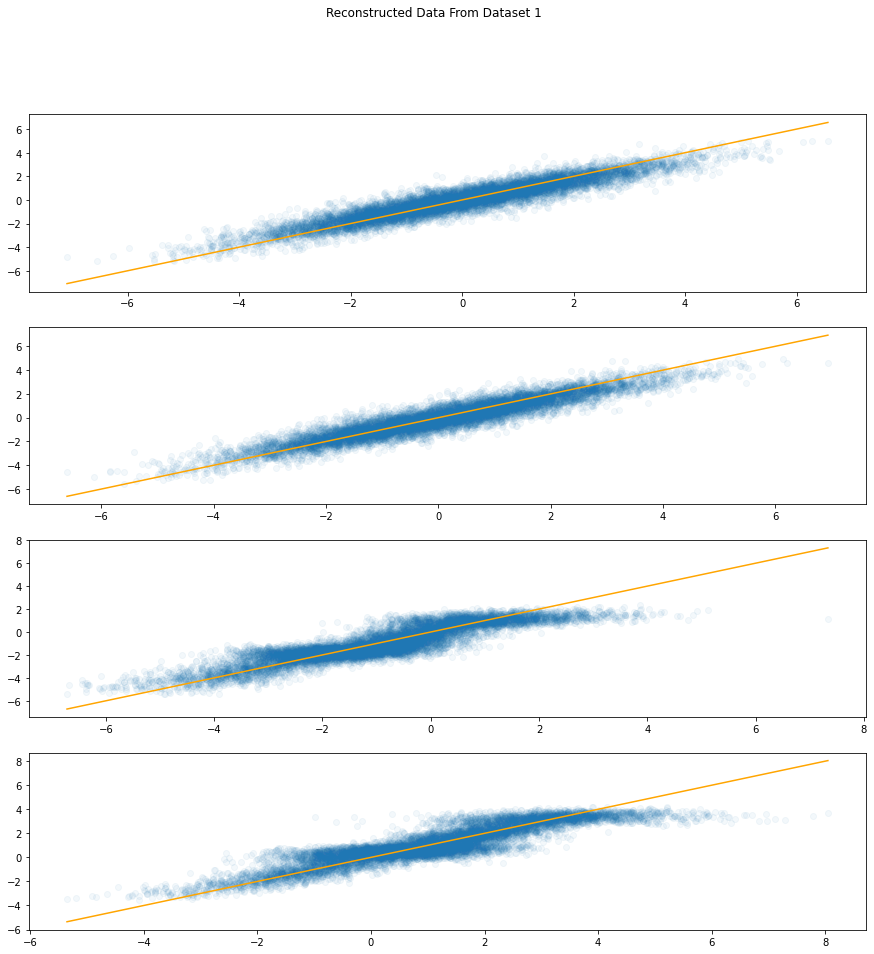

In [296]:
fig = plot_pairs(df_2_test.values, a_recon_2)
fig.show()

In [297]:
tmp_n = Normalizer()
mean_squared_error(tmp_n.fit_transform(df_2_test.values), tmp_n.transform(a_recon_2))

0.05627894540980949

In [298]:
a_pipe_3 = pipeline.Pipeline(
    [('norm', StandardScaler()),
    ('auto', autoencoder(n_components = 2))]
)

a_pipe_3.fit(df_3, auto__n_epochs = 50, auto__batch_size = 10)

a_comp_3 = a_pipe_3.transform(df_3_test)

a_recon_3 = a_pipe_3.inverse_transform(a_comp_3)

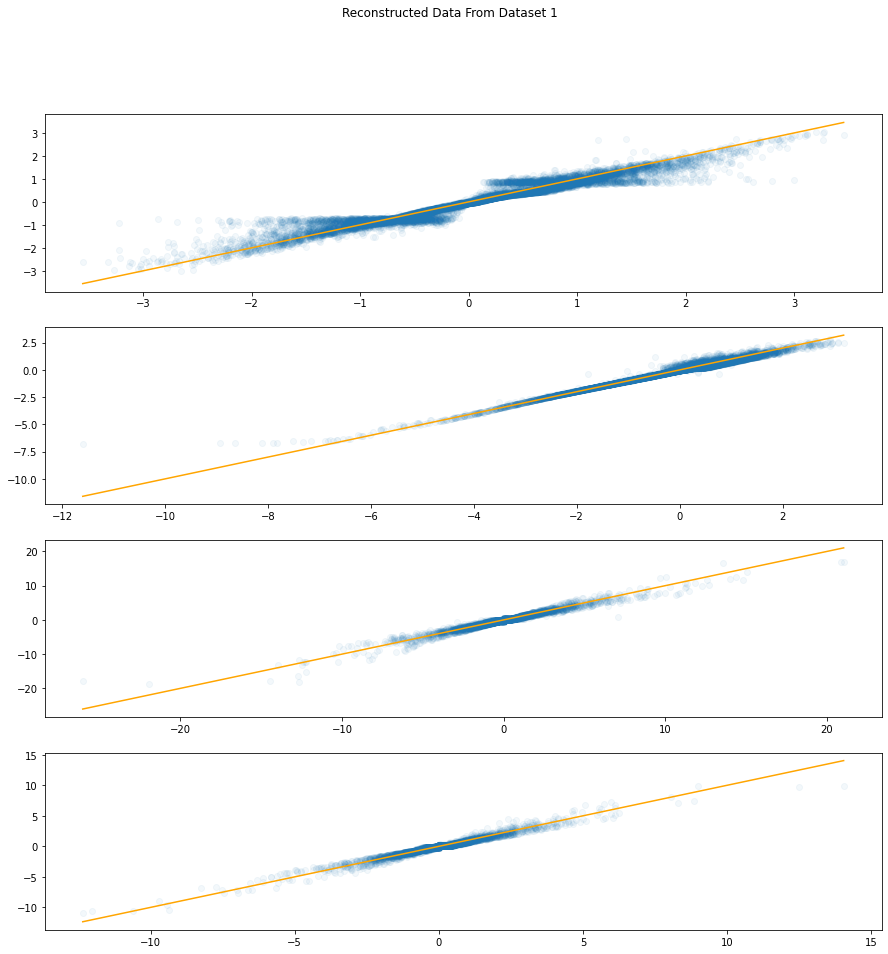

In [299]:
fig = plot_pairs(df_3_test.values, a_recon_3)
fig.show()

In [300]:
tmp_n = Normalizer()
mean_squared_error(tmp_n.fit_transform(df_3_test.values), tmp_n.transform(a_recon_3))

0.019166895752637487

And for reference, let's do a side-by-side comparison of the risk scores.

In [303]:
tmp_n = Normalizer()
pca_e = mean_squared_error(tmp_n.fit_transform(df_1_test.values), tmp_n.transform(recon_1))
ae_e = mean_squared_error(tmp_n.fit_transform(df_1_test.values), tmp_n.transform(a_recon_1))

print("Dataset 1 (Independent Variables)")
print("PCA MSE: {pca}\nAE MSE:  {ae}".format(pca=pca_e, ae = ae_e))

Dataset 1 (Independent Variables)
PCA MSE: 0.0891492374449166
AE MSE:  0.03446808565196767


In [306]:
tmp_n = Normalizer()
pca_e = mean_squared_error(tmp_n.fit_transform(df_2_test.values), tmp_n.transform(recon_2))
ae_e = mean_squared_error(tmp_n.fit_transform(df_2_test.values), tmp_n.transform(a_recon_2))

print("Dataset 2 (Linearly Dependent Variables)")
print("PCA MSE: {pca}\nAE MSE:  {ae}".format(pca=pca_e, ae = ae_e))

Dataset 2 (Linearly Dependent Variables)
PCA MSE: 0.06913765452419332
AE MSE:  0.05627894540980949


In [307]:
tmp_n = Normalizer()
pca_e = mean_squared_error(tmp_n.fit_transform(df_3_test.values), tmp_n.transform(recon_3))
ae_e = mean_squared_error(tmp_n.fit_transform(df_3_test.values), tmp_n.transform(a_recon_3))

print("Dataset 3 (Non-Linearly Dependent Variables)")
print("PCA MSE: {pca}\nAE MSE:  {ae}".format(pca=pca_e, ae = ae_e))

Dataset 3 (Non-Linearly Dependent Variables)
PCA MSE: 0.07180342373762666
AE MSE:  0.019166895752637487


In all cases, our autoencoder did a significantly better job than Principal Components Analysis (using a raw MSE evaluation metric).  There were also some problems with our Autoencoder outputs (consider the strange tails occurring in F1 and F2 in dataset 1).  However, Autoencoders can be further improved by introducing more layers, better regularization, and other tools that are typically used to improve neural networks.

# Review <a name='review' />

In this notebook, we set out to find ways to compress data by reducing the number of features that we had to deal with.  We decided that we wanted to evaluate our algorithms by building an inversion algorithm, which could reconstruct the original data.  Then, we could easily see how good our algorithm was.

We started by exploring linear transformations in the form of Principal Components Analysis (PCA).  This algorithm is an analytical solution to an optimization problem which uses a single linear transformation (matrix multiplication) to obtain a compressed dataset and a second linear transformation to reconstitute an approximation of our original dataset.  We demonstrated this to be the case byy training a neural network with only linear layers that performed the same task, and we saw that the results of both solutions were similarly successful.

We then introduced an alteration to our PCA neural network in which we used several nonlinear transformations (along with several large hidden layers) in order to obtain a better compression.

### Moving Forward

In the forthcoming notebooks, we will work with both compressed and uncompressed versions of our datasets to explore other unsupervised learning tasks.  The notebook *The Brainy Bunch* will introduce some basic ideas about clustering, and *Angels in the Outliers* will describe how and why we can use unsupervised learning to detect anomalies and outliers.  We will also take a brief aside in *Acting Out* to explore how a slight alteration to the autoencoder framework has revolutionized the practice of Natural Language Processing.